In [ ]:
from concurrent.futures import ProcessPoolExecutor
import os, glob, shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


In [ ]:
groupID = [1, 5, 7]
phaseID = [1, 2, 3]
groupStr = ['Sham', 'Right', 'Left']
phaseStr = ['Pre', 'Stim', 'Post']
# voi = ['mu_t', 'b', 'a', 'sigma']
voi = ['mu_t']

phaseCompare = [(1, 2), (1, 3)]
stat2show = 'density'  # seaborn histplot stat
groupCompare = [(1, 5), (1, 7)]
ncol = 4
nrow = len(groupID)

output_dir = "Figures"
data_dir = 'Results'
all_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]


Done processing all_a-Normal(0.00,1.00)_b-HalfCauchy(NA,1.00)_sig_t-HalfNormal(NA,0.25)_sigma-HalfCauchy(NA,1.00)


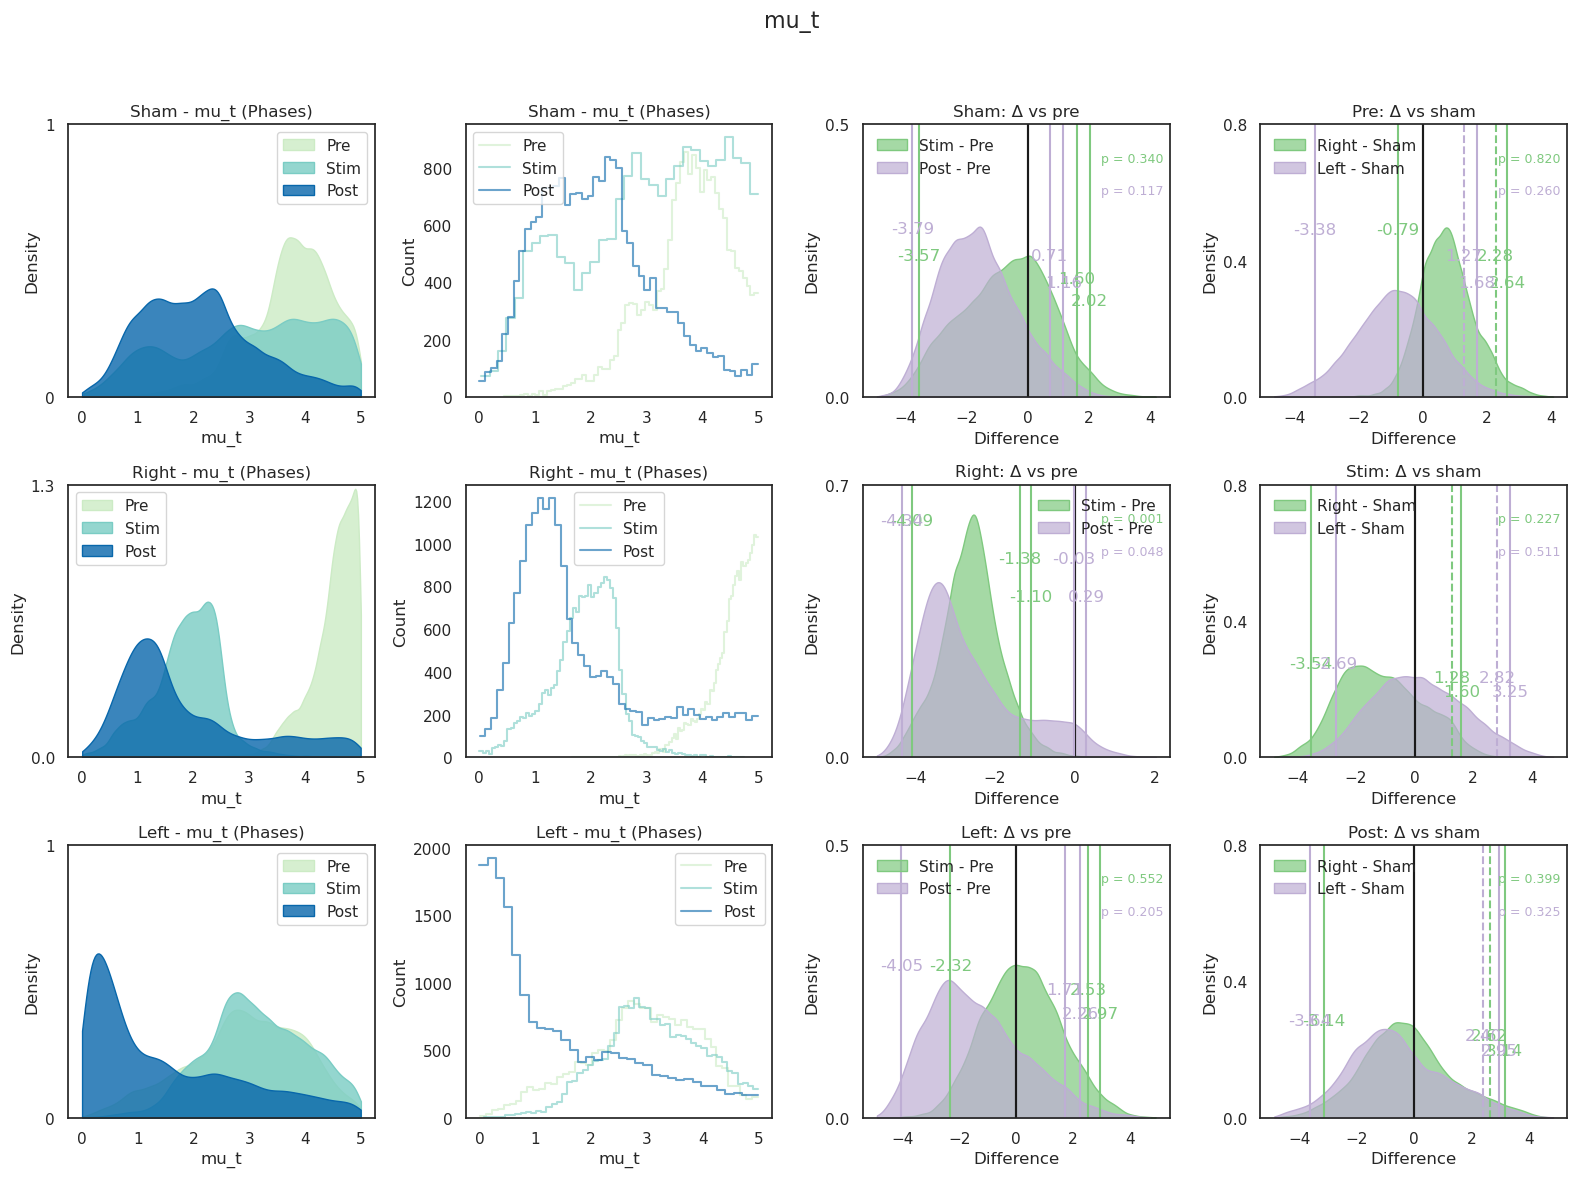

In [ ]:

def process_folder(cur_folder):
    folder_path = os.path.join(data_dir, cur_folder)
    dfs = []

    for g in groupID:
        for p in phaseID:
            pattern = os.path.join(folder_path, f'post_group{g}_phase{p}*.csv')
            files = glob.glob(pattern)
            if files:
                df = pd.read_csv(files[0])
                df['group'] = g
                df['phase'] = p
                dfs.append(df)

    post_tbl = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    expected_groups = set(groupID)
    expected_phases = {1, 2, 3}
    loaded_groups = set(post_tbl['group'].unique())
    loaded_phases = set(post_tbl['phase'].unique())

    if post_tbl.empty or not expected_groups.issubset(loaded_groups) or not expected_phases.issubset(loaded_phases):
        print(f"  Incomplete data in {cur_folder}, skipping...")
        return

    sns.set(style='white')

    pal = sns.color_palette("GnBu", 7)
    myColors_phase = [pal[1], pal[3], pal[6]]   # picks 2, 4, 7


    diff_colors = sns.color_palette("Accent", 3)  # for (pre->stim, pre->post)

    for v, var in enumerate(voi):
        var_folder = os.path.join(output_dir, 'parameters', var)
        os.makedirs(var_folder, exist_ok=True)
        save_path = os.path.join(var_folder, f"{var}_{stat2show}_{cur_folder}.png")

        fig, axes = plt.subplots(nrow, ncol, figsize=(4 * ncol, 4 * nrow))
        # fig, axes = plt.subplots(nrow, ncol, figsize=(3.6 * ncol, 4 * nrow))

        if nrow == 1:
            axes = np.expand_dims(axes, 0)

        for g_idx, g in enumerate(groupID):
            # ---- Col 1: three phases overlaid (filled) ----
            ax = axes[g_idx, 0]
            for p_idx, p in enumerate(phaseID):
                data = post_tbl.loc[(post_tbl['group'] == g) & (post_tbl['phase'] == p), var]
                # sns.histplot(data, stat=stat2show, color=myColors_phase[p_idx], ax=ax,
                #              kde=False, element='step', fill=True, alpha=0.8,line_kws={"alpha": 0.8})
                sns.kdeplot(data=data, ax=ax, fill=True, bw_adjust=0.8, cut=0, alpha=0.8,
                            color=myColors_phase[p_idx])
            ax.set_title(f"{groupStr[g_idx]} - {var} (Phases)")
            ax.legend(phaseStr)
            
            ylim = ax.get_ylim()
            ytop = ylim[1]   
            ytop = max(1, ytop)
            ytop = round(ytop, 1)  # keep one decimal
            ax.set_ylim(0, ytop)
            ax.set_yticks([0, ytop])

            # ---- Col 2: three phases overlaid (outline only) ----

            ax = axes[g_idx, 1]
            for p_idx, p in enumerate(phaseID):
                data = post_tbl.loc[(post_tbl['group'] == g) & (post_tbl['phase'] == p), var]
                sns.histplot(data, color=myColors_phase[p_idx], ax=ax,
                             kde=False, element='step', fill=False, alpha=0.6)
            ax.set_title(f"{groupStr[g_idx]} - {var} (Phases)")
            ax.legend(phaseStr)

            # ---- Col 3: posterior differences (stim−pre & post−pre), different colors ----
                
            ax2 = axes[g_idx, 2]

            for c_idx, (p1, p2) in enumerate(phaseCompare):
                # ax1 = axes[g_idx, 1 + c_idx * 2]
                data1 = post_tbl.loc[(post_tbl['group'] == g) & (post_tbl['phase'] == p1), var]
                data2 = post_tbl.loc[(post_tbl['group'] == g) & (post_tbl['phase'] == p2), var]

                # diff_data = data2.values[:, None] - data1.values[None, :]
                diff_data = data2.values - data1.values

                diff_data = diff_data.flatten()
                np.random.seed(0)

                # sns.histplot(diff_data, stat=stat2show, color=diff_colors[c_idx % 2], ax=ax2,
                #              kde=False, element='step', fill=True, alpha=0.7, label=f'{phaseStr[p2-1]} - {phaseStr[0]}')
                sns.kdeplot(data=diff_data, ax=ax2, fill=True, bw_adjust=0.8, cut=0, alpha=0.7,
                            color=diff_colors[c_idx % 2], label=f'{phaseStr[p2-1]} - {phaseStr[0]}')
                
                ax2.axvline(0, color='k', linestyle='-')
                
                CI = np.percentile(diff_data, [2.5,95, 97.5])
                for ci_val in CI:
                    ax2.axvline(ci_val, color=diff_colors[c_idx % 2], linestyle='-')
                ylim = ax2.get_ylim()
                ytop = ylim[1]
                for i, ci_val in enumerate(CI):
                    ax2.text(ci_val, ytop * (0.9 - 0.15 * i), f"{ci_val:.2f}",
                             ha='center', va='bottom',color=diff_colors[c_idx % 2])
                p_val = np.mean(diff_data > 0)
                
                ax2.text(0.98, 0.9 - 0.12*c_idx, f"p = {p_val:.3f}",
                         transform=ax2.transAxes, ha='right', va='top', fontsize=9,color=diff_colors[c_idx % 2])
            
            ylim = ax2.get_ylim()            
            ytop = max(0.5, ylim[1])
            ytop = round(ytop, 1)  # force to 1 decimal
            ax2.set_ylim(0, ytop)
            ax2.set_yticks([0, ytop])
            ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

            ax2.set_title(f"{groupStr[g_idx]}: Δ vs pre")
            ax2.set_xlabel("Difference")
            ax2.legend(frameon=False)

        # ---- Col 4: sham vs right, sham vs left at pre/stim/post ----
        
        for p_idx, p in enumerate(phaseID):

            ax3 = axes[p_idx, 3]
            for c_idx, (g1, g2) in enumerate(groupCompare):
                data1 = post_tbl.loc[(post_tbl['phase'] == p) & (post_tbl['group'] == g1), var]
                data2 = post_tbl.loc[(post_tbl['phase'] == p) & (post_tbl['group'] == g2), var]
                diff_data = data2.values - data1.values

                diff_data = diff_data.flatten()
                # sns.histplot(diff_data, stat=stat2show, color=diff_colors[c_idx % 2], ax=ax3,
                #              kde=False, element='step', fill=True, alpha=0.7,label=f'{groupStr[groupID.index(g2)]} - {groupStr[0]}')
                sns.kdeplot(data=diff_data, ax=ax3, fill=True, bw_adjust=0.8, cut=0, alpha=0.7,
                                            color=diff_colors[c_idx % 2], label=f'{groupStr[groupID.index(g2)]} - {groupStr[0]}')
                ax3.axvline(0, color='k', linestyle='-')
                
                CI = np.percentile(diff_data, [2.5, 95, 97.5])
                for ci_val in CI:
                    linestyle = '--' if ci_val == CI[1] else '-'
                    ax3.axvline(ci_val, color=diff_colors[c_idx % 2], linestyle=linestyle)
                ylim = ax3.get_ylim()
                ytop = ylim[1]

                for i, ci_val in enumerate(CI):
                    ax3.text(ci_val, ytop * (0.9 - 0.15 * i), f"{ci_val:.2f}",
                             ha='center', va='bottom',color=diff_colors[c_idx % 2])
                p_val = np.mean(diff_data > 0)
                ax3.text(0.98, 0.9 - 0.12*c_idx, f"p = {p_val:.3f}",
                         transform=ax3.transAxes, ha='right', va='top', fontsize=9,color=diff_colors[c_idx % 2])
            
            ylim = ax3.get_ylim()
            
            ytop = max(0.8, ylim[1])
            
            ytop = round(ytop, 1)  # force to 1 decimal
            ax3.set_ylim(0, ytop)
            ax3.set_yticks([0, 0.4, ytop])
            ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

            ax3.set_title(f"{phaseStr[p_idx]}: Δ vs sham")
            ax3.set_xlabel("Difference")
            ax3.legend(frameon=False)


        plt.suptitle(var, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        fig.savefig(save_path, dpi=300,)
        
        # plt.close(fig)

    print(f"Done processing {cur_folder}")
    
first_folder = 'all_a-Normal(0.00,1.00)_b-HalfCauchy(NA,1.00)_sig_t-HalfNormal(NA,0.25)_sigma-HalfCauchy(NA,1.00)'
process_folder(first_folder)